In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner

# Simple bump on power law
As a simple example: Gaussian signal with parameters (Amplitude, Mean, Std) wich is on top of a exponential background with parameters (Amplitude, Exponent)
$$
x_b = A_b y^{n_b}
$$
$$
x_s = A_s exp(-\frac{(y-\mu_s)^2}{2\sigma_s^2})
$$
And x is drawn from a combined Poisson distribution
$$
x \sim Pois(x_b + x_s)

In [131]:
def forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal
    x = x_b + x_s  # Total signal
    return x

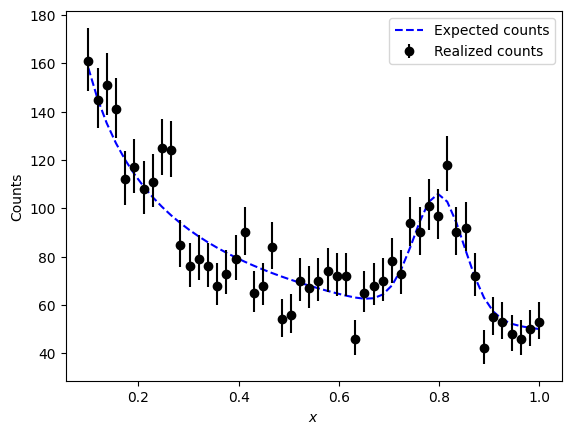

In [132]:
def poisson_interval(k, alpha=0.32): 
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = forward_model(y, amp_s=50, mu_s=0.8, std_s=0.05, amp_b=50, exp_b=-0.5)  

# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='blue', ls='--', label="Expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel("$x$")
plt.ylabel("Counts")

plt.legend()

## Explicit likelihood
In this toy example we can write down the explicit log likelihood. Fucus on just the signal amplitude and mean for simplicity. We set:
$$
\sigma_s = 0.05;\quad A_b = 50;\quad n_b = -0.5
$$

In this case the likelihood is:


In [133]:
#Log likelihood for a gaussian bump on top of fixed power law background
def log_like_sig(params, y, x):
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    mu = forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([50, 0.8], y, x)


-187.84620210715192

Get a estimate for the max likelihood estimate:

In [134]:
# Initial guess for the parameters
initial_guess = [100., 0.1]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_like_sig(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (50, 0.8)))


MLE parameters: [51.34666366  0.79564414]; true parameters: (50, 0.8)


And we approximate the posterior using MCMC sampling with emcee:

In [135]:
# Log prior function for data
def log_prior(thetas):
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf

# Log posterior function for data
def log_post(thetas, y, x):
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    
# MCMC sampling
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 934.79it/s]


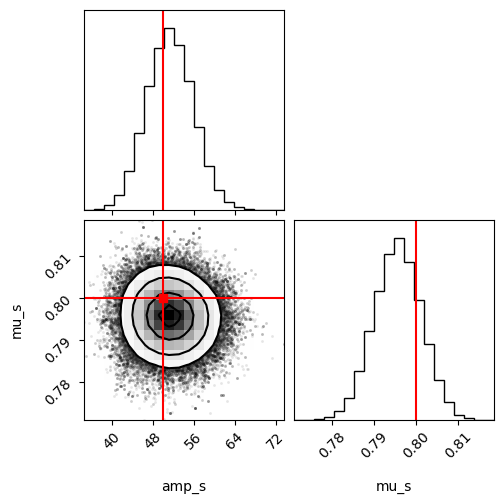

In [136]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], smooth=1, truth_color="red");

## Neural likelihood-ratio estimation (NRE)

Now we want to approximate the posterior using NRE. To do this we draw samples from the joint $\{x,\theta\} \sim p(x,\theta)$ as well as from the marginal distributions $\{x,\theta\} \sim p(x)p(\theta)$. In this case we approximate the likelihood to evidence ratio:
$$
r(x,\theta) = \frac{p(x,\theta)}{p(x)p(\theta)} = \frac{p(x|\theta)}{p(x)}
$$

In [137]:
# Simulator forward model with fixed background
def simulator(thetas, y):
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    x_mu = forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

# Test it out
simulator([50, 0.8], y)


array([139, 144, 137, 133, 102, 124,  95, 126, 100,  92,  94,  80,  78,
        91,  85,  81,  71,  76,  73,  79,  78,  82,  79,  68,  63,  57,
        61,  53,  65,  55,  56,  55,  54,  61,  67,  87,  80, 115, 119,
       109,  95,  74,  74,  69,  53,  51,  52,  56,  61,  49])

Begin by sampling some data

In [138]:
n_train = 50000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))  # Parameter proposal
x_samples = np.array([simulator(theta, y) for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


100%|██████████| 50000/50000 [00:00<00:00, 61133.51it/s]


For the classifier use a MLP

In [139]:
# MLP for classifier
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

Create a neural ratio estimator class with binary cross entropy loss, to discriminate between the samples from the joint and the marginals.

In [140]:
# Neural likelihood to evidence ratio estimator
class NeuralRatioEstimator(pl.LightningModule):
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [141]:
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2)
nre.loss(x_samples[:64], theta_samples[:64])


tensor([0.6547, 0.7333, 0.6541, 0.7338, 0.6554, 0.7321, 0.6544, 0.7334, 0.6540,
        0.7339, 0.6547, 0.7328, 0.6542, 0.7336, 0.6541, 0.7340, 0.6538, 0.7343,
        0.6544, 0.7335, 0.6544, 0.7332, 0.6535, 0.7347, 0.6545, 0.7332, 0.6547,
        0.7329, 0.6548, 0.7332, 0.6549, 0.7329, 0.6545, 0.7331, 0.6546, 0.7331,
        0.6541, 0.7336, 0.6544, 0.7334, 0.6541, 0.7338, 0.6544, 0.7335, 0.6573,
        0.7305, 0.6552, 0.7324, 0.6547, 0.7332, 0.6542, 0.7341, 0.6538, 0.7340,
        0.6547, 0.7329, 0.6546, 0.7334, 0.6551, 0.7327, 0.6563, 0.7313, 0.6546,
        0.7335, 0.6549, 0.7327, 0.6549, 0.7327, 0.6546, 0.7332, 0.6543, 0.7335,
        0.6549, 0.7332, 0.6549, 0.7328, 0.6546, 0.7331, 0.6545, 0.7332, 0.6548,
        0.7328, 0.6557, 0.7320, 0.6545, 0.7333, 0.6540, 0.7337, 0.6547, 0.7332,
        0.6545, 0.7330, 0.6547, 0.7332, 0.6546, 0.7331, 0.6572, 0.7305, 0.6574,
        0.7303, 0.6544, 0.7334, 0.6553, 0.7325, 0.6542, 0.7337, 0.6547, 0.7331,
        0.6548, 0.7330, 0.6547, 0.7328, 

Now train the network

In [142]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False)


In [143]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 73.0 K | train
--------------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


/Users/jonathanhering/miniforge3/envs/sbi_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/jonathanhering/miniforge3/envs/sbi_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 352/352 [00:05<00:00, 67.54it/s, v_num=6] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 352/352 [00:05<00:00, 67.32it/s, v_num=6]


The classifier logits are not an estimator for the likelihood ratio. This way we can write down the log likelihood and use MCMC to sample the approximated posterior

In [144]:
def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
        
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze()

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

log_like(theta_test, x_test)

tensor(4.8825, grad_fn=<SqueezeBackward0>)

In [145]:
def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return (lp + log_like(theta, x)).item()

Use MCCM sampling

In [146]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:18<00:00, 277.49it/s]


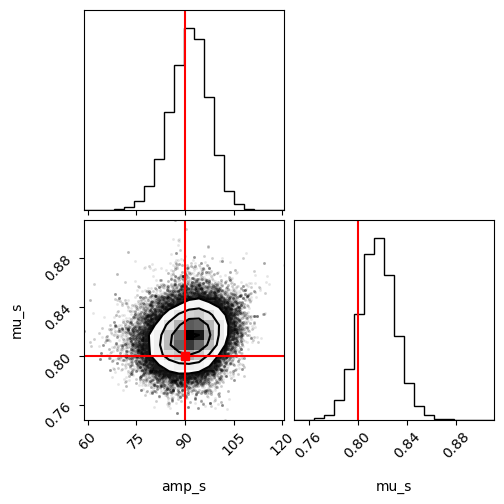

In [147]:
#Plot approx. posterior
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 0.8], truth_color="red");